In [ ]:
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import albumentations as A
from tensorflow.keras.applications import EfficientNetB1
#from keras.preprocessing.image import load_img
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Unzipping Data

In [ ]:
import tarfile
data_zipped = tarfile.open('drive/My Drive/ASDRP/Data/UTKface_inthewild/part1.tar.gz')

In [ ]:
len(data_zipped.getnames())

10138

In [ ]:
import random

In [ ]:
for i in tqdm(random.sample(data_zipped.getnames(), 1)):
  if not os.path.isfile('drive/My Drive/ASDRP/Data/utk_cropped/' + i): 
    data_zipped.extract(i, 'drive/My Drive/ASDRP/Data/utk_cropped')
    print(i)

100%|██████████| 1/1 [00:02<00:00,  2.29s/it]

part1/37_0_0_20170109001555863.jpg


In [ ]:
def get_file_count(file_path):
  dir_path = r''+file_path
  count = 0
  for path in tqdm(os.listdir(dir_path)):
      # check if current path is a file
      if os.path.isfile(os.path.join(dir_path, path)):
          count += 1
  return count

In [ ]:
get_file_count('drive/My Drive/ASDRP/Data/utk_cropped/part1')

100%|██████████| 5000/5000 [00:00<00:00, 5676.17it/s]


5000

In [ ]:
data = 'drive/My Drive/ASDRP/Data/utk_cropped/part1'

In [ ]:
image_paths = []
ages = []
genders = []
races = []

In [ ]:
# For loop to create individual lists of attributes
count = 0
for image in tqdm(os.listdir(data)):
    image_path = os.path.join(data, image)
    vals = image.split('_')
    age = int(vals[0])
    gender = int(vals[1])

    try:
      race = int(vals[2])    
    except:
      count += 1
      continue

    image_paths.append(image_path)
    ages.append(age)
    genders.append(gender)
    races.append(race) 

100%|██████████| 5000/5000 [00:00<00:00, 345864.93it/s]


In [ ]:
# Making dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_paths, ages, genders, races

In [ ]:
df['race'].value_counts()

0    2681
2     834
3     720
4     542
1     222
Name: race, dtype: int64

In [ ]:
# dataframe for later reference
# Making dataframe
# df_ref = pd.DataFrame()
# df_ref['image'], df_ref['age'], df_ref['gender'], df_ref['race'] = image_paths, ages, genders, races

In [ ]:
df['gender'].value_counts()

1    2752
0    2247
Name: gender, dtype: int64

In [ ]:
df.to_csv(r'drive/My Drive/ASDRP/Experiments/simple-cnn-v3/df.csv', index = False, header=True)

In [ ]:
df.head()

,image,age,gender,race
0,drive/My Drive/ASDRP/Data/utk_cropped/part1/20...,20,0,0
1,drive/My Drive/ASDRP/Data/utk_cropped/part1/21...,21,0,0
2,drive/My Drive/ASDRP/Data/utk_cropped/part1/18...,18,0,3
3,drive/My Drive/ASDRP/Data/utk_cropped/part1/31...,31,0,3
4,drive/My Drive/ASDRP/Data/utk_cropped/part1/12...,12,0,3


Adding new row to make 5000

In [ ]:
row = {'image': 'drive/My Drive/ASDRP/Data/utk_cropped/part1/37_0_0_20170109001555863.jpg', 'gender': 0, 'age': 37, 'race': 0}
df = df.append(row, ignore_index = True)


In [ ]:
df.tail()

,image,age,gender,race
4995,drive/My Drive/ASDRP/Data/utk_cropped/part1/69...,69,1,0
4996,drive/My Drive/ASDRP/Data/utk_cropped/part1/57...,57,1,0
4997,drive/My Drive/ASDRP/Data/utk_cropped/part1/53...,53,1,0
4998,drive/My Drive/ASDRP/Data/utk_cropped/part1/59...,59,1,0
4999,drive/My Drive/ASDRP/Data/utk_cropped/part1/37...,37,0,0


In [ ]:
df.to_csv(r'drive/My Drive/ASDRP/Experiments/simple-cnn-v3/df.csv', index = False, header=True)

In [ ]:
df.shape[0]

5000

In [ ]:
df = pd.read_csv('drive/My Drive/ASDRP/Experiments/simple-cnn-v3/df.csv')

# New way

In [ ]:
df = pd.read_csv('drive/My Drive/Fairfake - ASDRP/Experiments/simple-cnn-v3/df.csv')

In [ ]:
df.shape

(5000, 4)

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img_inp = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)
        features.append(img_inp)
        
    features = np.array(features)
    # ignore this step if using RGB
    #features = features.reshape(len(features), 128, 128, 3)
    return features


In [ ]:
#X = extract_features(df['image'])

100%|██████████| 5000/5000 [29:50<00:00,  2.79it/s]


In [ ]:
#X.shape

(9778, 64, 64, 3)

In [ ]:
#np.save('drive/My Drive/ASDRP/Experiments/simple-cnn-v3/features.npy', X)

In [ ]:
#X = np.load('drive/My Drive/ASDRP/Experiments/simple-cnn-v3/features.npy')
#X = X / 255.0

In [ ]:
df['race'].value_counts()

0    2682
2     834
3     720
4     542
1     222
Name: race, dtype: int64

In [ ]:
df[df['race'] != 0]['gender'].value_counts()

1    1313
0    1005
Name: gender, dtype: int64

In [ ]:
indices = []
#black_total = 222
#asian_total = 834
#indian_total = 720
#others_total = 542
female_total = 1313

for i in tqdm(range(len(df))):

  if df.iloc[i]['gender'] == 1 and df.iloc[i]['race'] != 0 and female_total > 500:
    indices.append(i)
    female_total -= 1



100%|██████████| 5000/5000 [00:01<00:00, 3534.90it/s]


In [ ]:
len(indices)

813

In [ ]:
df = df.drop(indices)
df = df.reset_index()

In [ ]:
df['gender'].value_counts()

0    2248
1    1939
Name: gender, dtype: int64

In [ ]:
import pickle
images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/list_of_tensors_generated.pickle", "rb"))

In [ ]:
images_reduced = []

for i in range(len(images)):
  if i not in indices:
    images_reduced.append(images[i])

In [ ]:
len(images_reduced)

4187

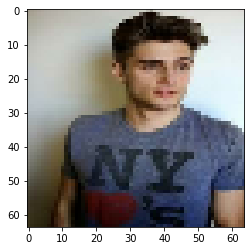

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(images_reduced[0], interpolation='nearest')
plt.show()

In [ ]:
race_dict = {'White\n(M)':0, 'Black\n(M)': 0, 'Asian\n(M)': 0, 'Indian\n(M)': 0, 'Others\n(M)': 0, 'White\n(F)':0, 'Black\n(F)': 0, 'Asian\n(F)': 0, 'Indian\n(F)': 0, 'Others\n(F)': 0}
for i in tqdm(range(len(df))):
  if df.iloc[i]['gender'] == 0:
    if df.iloc[i]['race'] == 0:
      race_dict['White\n(M)'] += 1
    if df.iloc[i]['race'] == 1:
      race_dict['Black\n(M)'] += 1
    if df.iloc[i]['race'] == 2:
      race_dict['Asian\n(M)'] += 1
    if df.iloc[i]['race'] == 3:
      race_dict['Indian\n(M)'] += 1
    if df.iloc[i]['race'] == 4:
      race_dict['Others\n(M)'] += 1
  else:
    if df.iloc[i]['race'] == 0:
      race_dict['White\n(F)'] += 1
    if df.iloc[i]['race'] == 1:
      race_dict['Black\n(F)'] += 1
    if df.iloc[i]['race'] == 2:
      race_dict['Asian\n(F)'] += 1
    if df.iloc[i]['race'] == 3:
      race_dict['Indian\n(F)'] += 1
    if df.iloc[i]['race'] == 4:
      race_dict['Others\n(F)'] += 1
  


100%|██████████| 4187/4187 [00:07<00:00, 581.93it/s] 


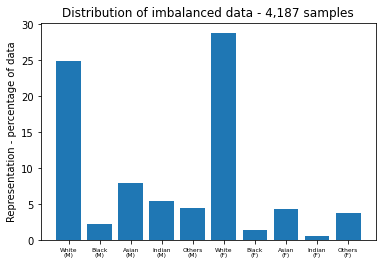

In [ ]:
names = list(race_dict.keys())
values = list(race_dict.values())

for i in range(len(values)):
  values[i] /= 5000
  values[i] *= 100

plt.bar(range(len(race_dict)), values, tick_label=names)
plt.tick_params(axis='x', which='major', labelsize=6)
plt.ylabel("Representation - percentage of data")
plt.title("Distribution of imbalanced data - 4,187 samples")
plt.savefig('dist.png', dpi=400)
plt.show()

In [ ]:
values

[24.86,
 2.2399999999999998,
 7.9399999999999995,
 5.42,
 4.5,
 28.78,
 2.1999999999999997,
 8.74,
 8.98,
 6.34]

In [ ]:
#images = np.array(images)

In [ ]:
input_shape = (64, 64, 3)

In [ ]:
y_gender = np.array(df['gender'])
y_race = np.array(df['race'])

In [ ]:
y_stack = np.vstack((y_gender,y_race))
Y = y_stack[0]

In [ ]:
val_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))

In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/df_test.csv')  

In [ ]:
Y_val = np.array(df_val['gender'])

In [ ]:
len(images_reduced)

4187

In [ ]:
test_indices = df.sample(n=837, random_state=40).index

In [ ]:
test_indices

Int64Index([1074, 1898,  619, 4095, 3357, 3300, 3352, 1226, 2737,  695,
            ...
             671, 1702, 2907, 1202, 1282, 1107, 2328, 3893, 1895, 1234],
           dtype='int64', length=837)

In [ ]:
test_images = []
for i in test_indices.tolist():
  test_images.append(images[i])

In [ ]:
y_gender_test = np.array(df.iloc[test_indices]['gender'])

In [ ]:
len(y_gender_test)

837

In [ ]:
len(Y)

4187

In [ ]:
len(images_reduced)

4187

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(images_5k[2000], interpolation='nearest')
plt.show()

In [ ]:
images_reduced = [i for j, i in enumerate(images_reduced) if j not in test_indices.tolist()]

In [ ]:
Y = np.delete(Y, test_indices)

IndexError: ignored

In [ ]:
images_reduced = np.array(images_reduced)
val_images = np.array(val_images)

In [ ]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
#dense_2 = Dense(256, activation='relu') (flatten)
#dense_3 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
#dropout_2 = Dropout(0.3) (dense_2)
#dropout_3 = Dropout(0.3) (dense_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
#output_2 = Dense(1, activation='softmax', name='race_out') (dropout_2)
#output_3 = Dense(1, activation='relu', name='age_out') (dropout_3)

model = Model(inputs=[inputs], outputs=[output_1])

model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [ ]:
len(images_reduced)

3488

In [ ]:
len(Y)

4163

In [ ]:
history = model.fit(x=images_reduced, y=Y, batch_size=32, epochs=50, validation_data=(val_images, Y_val))

Epoch 1/50
131/131 [==============================] - 14s 12ms/step - loss: 0.6921 - accuracy: 0.5297 - val_loss: 0.6985 - val_accuracy: 0.4470
Epoch 2/50
131/131 [==============================] - 1s 8ms/step - loss: 0.6833 - accuracy: 0.5491 - val_loss: 0.7109 - val_accuracy: 0.5070
Epoch 3/50
131/131 [==============================] - 1s 8ms/step - loss: 0.6446 - accuracy: 0.6152 - val_loss: 0.6414 - val_accuracy: 0.6290
Epoch 4/50
131/131 [==============================] - 1s 8ms/step - loss: 0.5960 - accuracy: 0.6582 - val_loss: 0.6797 - val_accuracy: 0.6510
Epoch 5/50
131/131 [==============================] - 1s 8ms/step - loss: 0.5608 - accuracy: 0.6998 - val_loss: 0.5873 - val_accuracy: 0.7000
Epoch 6/50
131/131 [==============================] - 1s 8ms/step - loss: 0.5266 - accuracy: 0.7287 - val_loss: 0.5677 - val_accuracy: 0.7040
Epoch 7/50
131/131 [==============================] - 1s 8ms/step - loss: 0.4927 - accuracy: 0.7514 - val_loss: 0.6146 - val_accuracy: 0.6990
Epoc

In [ ]:
model.save("drive/My Drive/ASDRP/Model Checkpoints/unbalanced_final.h5")

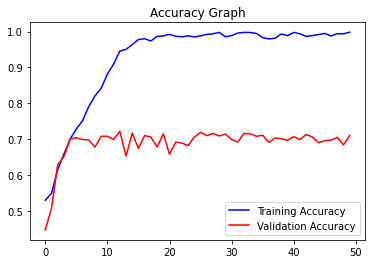

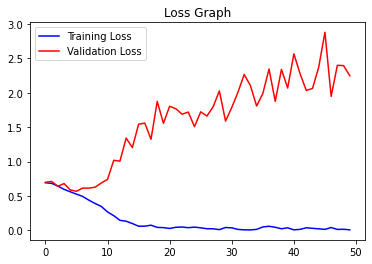

In [ ]:
# plot results for gender
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
model = load_model('drive/My Drive/ASDRP/Model Checkpoints/unbalanced_reduced.h5')

Original Gender: 0
Predicted Gender: 0


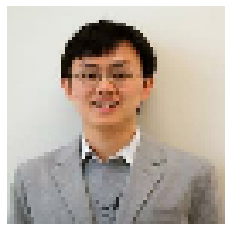

In [ ]:
import random
image_index = random.randint(0,2000)
print("Original Gender:", Y[image_index])
# predict from model
pred = model.predict(images_reduced[image_index].reshape(1, 64, 64, 3))
pred_gender = round(pred[0][0])
#pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender)
plt.axis('off')
plt.imshow(images_reduced[image_index].reshape(64, 64, 3));

TESTING

In [ ]:
test_images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))
test_images = np.array(test_images)

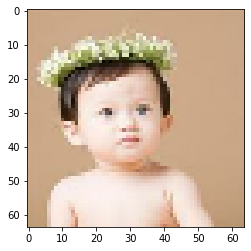

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(test_images[0], interpolation='nearest')
plt.show()

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ASDRP/Experiments/df_test.csv')  

In [ ]:
df_test

,image,age,gender,race
0,drive/My Drive/ASDRP/Experiments/test_data_rea...,2,1,2
1,drive/My Drive/ASDRP/Experiments/test_data_rea...,1,1,0
2,drive/My Drive/ASDRP/Experiments/test_data_rea...,76,1,0
3,drive/My Drive/ASDRP/Experiments/test_data_rea...,2,1,2
4,drive/My Drive/ASDRP/Experiments/test_data_rea...,5,1,0
...,...,...,...,...
995,drive/My Drive/ASDRP/Experiments/test_data_rea...,26,0,1
996,drive/My Drive/ASDRP/Experiments/test_data_rea...,9,0,1
997,drive/My Drive/ASDRP/Experiments/test_data_rea...,43,0,1
998,drive/My Drive/ASDRP/Experiments/test_data_rea...,90,0,1


In [ ]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(64, 64))
    return img


In [ ]:
final_test_images = [load(i) for i in tqdm(df_test.image)]


100%|██████████| 837/837 [10:56<00:00,  1.27it/s]


In [ ]:
y_gender_test = np.array(df_test['gender'])

In [ ]:
df_test['race'].value_counts()

2    200
0    200
3    200
4    200
1    200
Name: race, dtype: int64

In [ ]:
df_test['gender'].value_counts()

1    550
0    450
Name: gender, dtype: int64

In [ ]:
test_images = np.array(test_images)

In [ ]:
predictions_gender = []
for i in tqdm(test_images):
  pred = model.predict(i.reshape(1, 64, 64, 3))
  pred_gender = round(pred[0][0])

  predictions_gender.append(pred_gender)


100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]


In [ ]:
df_test = df.iloc[test_indices].reset_index()

In [ ]:
df_test

,image,age,gender,race
0,drive/My Drive/ASDRP/Experiments/test_data_rea...,2,1,2
1,drive/My Drive/ASDRP/Experiments/test_data_rea...,1,1,0
2,drive/My Drive/ASDRP/Experiments/test_data_rea...,76,1,0
3,drive/My Drive/ASDRP/Experiments/test_data_rea...,2,1,2
4,drive/My Drive/ASDRP/Experiments/test_data_rea...,5,1,0
...,...,...,...,...
995,drive/My Drive/ASDRP/Experiments/test_data_rea...,26,0,1
996,drive/My Drive/ASDRP/Experiments/test_data_rea...,9,0,1
997,drive/My Drive/ASDRP/Experiments/test_data_rea...,43,0,1
998,drive/My Drive/ASDRP/Experiments/test_data_rea...,90,0,1


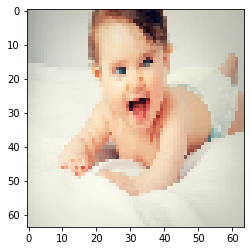

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(test_images[1], interpolation='nearest')
plt.show()

In [ ]:
len(y_gender_test)

1000

In [ ]:
def get_accuracy_both(race, gender):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender: 
      correct += 1
    if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender:
      total += 1
    #if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end:
    #  total += 1

    #  and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end
  
  return correct / total

def get_accuracy_race(race):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race: 
      correct += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return correct / total

def get_accuracy_gender(gender):
  correct = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['gender'] == gender: 
      correct += 1
    if df_test.iloc[i]['gender'] == gender:
      total += 1
  
  return correct / total

def get_accuracy_overall():
  correct = 0
  total = 837
  for i in range(837):
    if predictions_gender[i] == y_gender_test[i]: 
      correct += 1
  
  return correct / total

def get_false_positive(race):
  false_positives = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == 1 and y_gender_test[i] == 0 and df_test.iloc[i]['race'] == race: 
      false_positives += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return false_positives / total

def get_false_negative(race):
  false_negatives = 0
  total = 0
  for i in range(837):
    if predictions_gender[i] == 0 and y_gender_test[i] == 1 and df_test.iloc[i]['race'] == race: 
      false_negatives += 1
    if df_test.iloc[i]['race'] == race:
      total += 1
  
  return false_negatives / total

In [ ]:
get_accuracy_overall()

0.7192353643966547

In [ ]:
get_accuracy_both(0, 0)

0.6419753086419753

In [ ]:
get_accuracy_gender(0)

0.6937669376693767

In [ ]:
get_accuracy_race(1)

0.7083333333333334

In [ ]:
get_false_positive(4)

0.08955223880597014

In [ ]:
get_false_negative(4)

0.13432835820895522

In [ ]:
'''
ages = []
for image in tqdm(df_test.image):
    #image_path = os.path.join(data, image)
    vals = image.split('_')[0].split('/')
    age = int(vals[5])
    #ender = int(vals[1])


    ages.append(age)
'''

100%|██████████| 1300/1300 [00:00<00:00, 328252.07it/s]


In [ ]:
# df_test['age'] = ages

In [ ]:
X_test = extract_features(df_test['image'])

100%|██████████| 1300/1300 [07:35<00:00,  2.85it/s]


In [ ]:
np.save('drive/My Drive/ASDRP/Experiments/simple-cnn-v3/features_test.npy', X_test)

In [ ]:
y_gender_test = np.array(df_test['gender'])
y_age_test = np.array(df_test['age'])
X_test = X_test / 255.0

In [ ]:
predictions_gender = []
predictions_age = []
for i in tqdm(df_test.reset_index().index):
  pred = model.predict(X_test[i].reshape(1, 128, 128, 3))
  pred_gender = round(pred[0][0][0])
  pred_age = round(pred[1][0][0])

  predictions_gender.append(pred_gender)
  predictions_age.append(pred_age)


100%|██████████| 1300/1300 [00:57<00:00, 22.61it/s]


In [ ]:
predictions_age[20:30]

[59, 39, 23, 46, 46, 13, 45, 30, 34, 26]

In [ ]:
y_age_test[20:30]

array([61, 58, 30, 67, 68,  9, 37, 25, 29, 30])

In [ ]:
df_test = df_test.reset_index()

In [ ]:
df_test['race'].value_counts()

0    555
1    249
3    220
2    190
4     86
Name: race, dtype: int64

In [ ]:
def mae(y_true, predictions):
    predictions = np.array(predictions)
    y_true = np.delete(y_true, df_test[(df_test['race'] == 4)].index)
    predictions = np.delete(predictions, df_test[(df_test['race'] == 4)].index)
    return np.mean(np.abs(y_true - predictions))

In [ ]:
mae(y_age_test, predictions_age)

7.956342668863262

In [ ]:
def get_accuracy(race, gender, age_start, age_end):
  correct = 0
  total = 0
  for i in range(1300):
    if predictions_gender[i] == y_gender_test[i] and df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end: 
      correct += 1
    if df_test.iloc[i]['race'] == race and df_test.iloc[i]['gender'] == gender and df_test.iloc[i]['age'] >= age_start and df_test.iloc[i]['age'] <= age_end:
      total += 1
  
  return correct / total

In [ ]:
get_accuracy(4, 1, 10, 70)

0.868421052631579

# OLD BELOW

In [ ]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(64, 64))
    return img

In [ ]:
images = [load(i) for i in tqdm(df.image)]

100%|██████████| 4999/4999 [1:03:36<00:00,  1.31it/s]


In [ ]:
images.append(load(df.iloc[4999]['image']))

In [ ]:
len(images)

5000

In [ ]:
import pickle
#with open('/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/list_of_tensors_generated.pickle', 'wb') as handle:
#  pickle.dump(images, handle)
images = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/list_of_tensors_generated.pickle", "rb"))

In [ ]:
type(images)

list

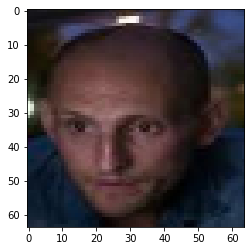

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(images[4999], interpolation='nearest')
plt.show()

In [ ]:
# indices_remove = df[df['race'] == 1].sample(n=1500, random_state = 42).index

In [ ]:
# df = df.drop(indices_remove)

In [ ]:
# images_new = [i for j, i in enumerate(images_5k) if j not in indices_remove]

In [ ]:
df['race'].value_counts()

0    2682
2     834
3     720
4     542
1     222
Name: race, dtype: int64

In [ ]:
race_dict = {'WM':0, 'BM': 0, 'AM': 0, 'IM': 0, 'OM': 0, 'WF':0, 'BF': 0, 'AF': 0, 'IF': 0, 'OF': 0}
for i in tqdm(range(len(df))):
  if df.iloc[i]['gender'] == 0:
    if df.iloc[i]['race'] == 0:
      race_dict['WM'] += 1
    if df.iloc[i]['race'] == 1:
      race_dict['BM'] += 1
    if df.iloc[i]['race'] == 2:
      race_dict['AM'] += 1
    if df.iloc[i]['race'] == 3:
      race_dict['IM'] += 1
    if df.iloc[i]['race'] == 4:
      race_dict['OM'] += 1
  else:
    if df.iloc[i]['race'] == 0:
      race_dict['WF'] += 1
    if df.iloc[i]['race'] == 1:
      race_dict['BF'] += 1
    if df.iloc[i]['race'] == 2:
      race_dict['AF'] += 1
    if df.iloc[i]['race'] == 3:
      race_dict['IF'] += 1
    if df.iloc[i]['race'] == 4:
      race_dict['OF'] += 1
  

 

100%|██████████| 5000/5000 [00:02<00:00, 1697.12it/s]


Text(0, 0.5, 'Number of examples in dataset')

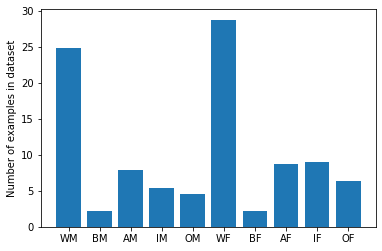

In [ ]:
names = list(race_dict.keys())
values = list(race_dict.values())

for i in range(len(values)):
  values[i] /= 5000
  values[i] *= 100

plt.bar(range(len(race_dict)), values, tick_label=names)

plt.ylabel("Number of examples in dataset")

In [ ]:
values

[24.86,
 2.2399999999999998,
 7.9399999999999995,
 5.42,
 4.5,
 28.78,
 2.1999999999999997,
 8.74,
 8.98,
 6.34]

In [ ]:
images = np.array(images)

In [ ]:
y_gender = [i for i in df['gender']]
# y_age = [i for i in df['age']]
y_race = [i for i in df['race']]

In [ ]:
len(y_gender)

5000

In [ ]:
y_stack = np.vstack((y_gender,y_race))

In [ ]:
X = images
Y = y_stack[0]

In [ ]:
Y_alias = y_stack[1]

In [ ]:
#from sklearn.model_selection import train_test_split
#X, X_test, Y, y_test = train_test_split(images, y_stack[0], test_size=0.2, random_state = 42)
#X_alias, X_alias2, Y_alias, y_alias2 = train_test_split(images, y_stack[1], test_size=0.2, random_state = 42)

In [ ]:
def create_new_model():
  model = tf.keras.applications.efficientnet.EfficientNetB0(
      include_top=True,
      weights=None,
      input_tensor=None,
      input_shape=(64,64,3),
      pooling=None,
      classes=1,
      classifier_activation='sigmoid',
  )
  #model.add(Flatten())
  return model

def get_model_name(k):
  return 'model_'+str(k)+'.h5'

Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 2.5744 - accuracy: 0.5080
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to /content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_1.h5
125/125 [==============================] - 21s 72ms/step - loss: 2.5744 - accuracy: 0.5080 - val_loss: 0.8829 - val_accuracy: 0.5500
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 1.4646 - accuracy: 0.5197
Epoch 2: val_accuracy did not improve from 0.55000
125/125 [==============================] - 5s 43ms/step - loss: 1.4646 - accuracy: 0.5197 - val_loss: 0.7982 - val_accuracy: 0.4500
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.5293
Epoch 3: val_accuracy did not improve from 0.55000
125/125 [==============================] - 6s 46ms/step - loss: 1.3888 - accuracy: 0.5293 - val_loss: 0.8598 - val_accuracy: 0.5500
Epoch 4/40
125/125 [==============================] - ETA: 0s - loss: 1.1466 -

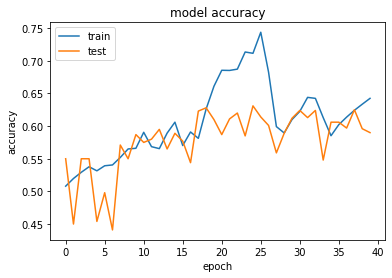

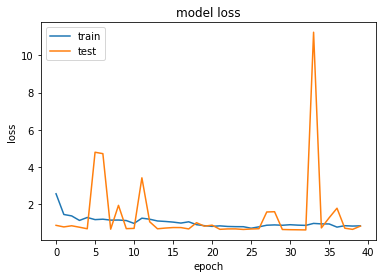

32/32 [==============================] - 1s 17ms/step - loss: 0.6633 - accuracy: 0.6310
Epoch 1/40
124/125 [============================>.] - ETA: 0s - loss: 2.9046 - accuracy: 0.5066
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to /content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_2.h5
125/125 [==============================] - 18s 75ms/step - loss: 2.8882 - accuracy: 0.5067 - val_loss: 0.7723 - val_accuracy: 0.4500
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 1.3563 - accuracy: 0.5268
Epoch 2: val_accuracy improved from 0.45000 to 0.55000, saving model to /content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_2.h5
125/125 [==============================] - 6s 51ms/step - loss: 1.3563 - accuracy: 0.5268 - val_loss: 0.6930 - val_accuracy: 0.5500
Epoch 3/40
124/125 [============================>.] - ETA: 0s - loss: 1.3481 - accuracy: 0.5272
Epoch 3: val_accuracy did not improve from 0.55000
125/125 [==========================

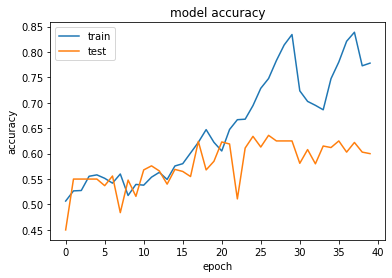

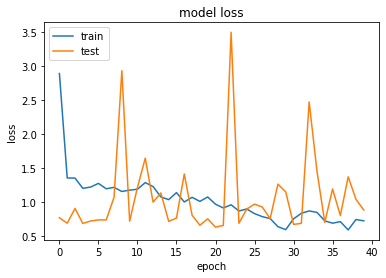

32/32 [==============================] - 1s 18ms/step - loss: 0.9298 - accuracy: 0.6360
Epoch 1/40
124/125 [============================>.] - ETA: 0s - loss: 2.8420 - accuracy: 0.5131
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to /content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_3.h5
125/125 [==============================] - 18s 74ms/step - loss: 2.8253 - accuracy: 0.5135 - val_loss: 0.7088 - val_accuracy: 0.5500
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 1.5032 - accuracy: 0.5340
Epoch 2: val_accuracy did not improve from 0.55000
125/125 [==============================] - 6s 46ms/step - loss: 1.5032 - accuracy: 0.5340 - val_loss: 1.0394 - val_accuracy: 0.5500
Epoch 3/40
125/125 [==============================] - ETA: 0s - loss: 1.4399 - accuracy: 0.5440
Epoch 3: val_accuracy did not improve from 0.55000
125/125 [==============================] - 7s 54ms/step - loss: 1.4399 - accuracy: 0.5440 - val_loss: 1.0149 - val_accurac

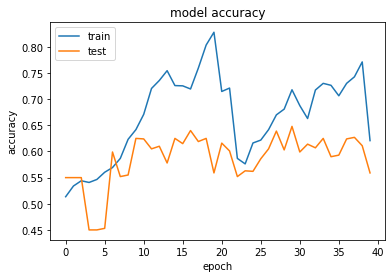

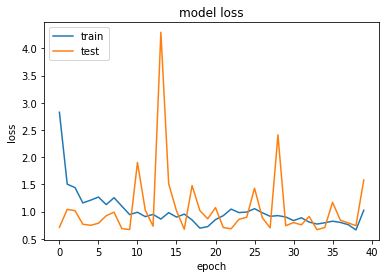

32/32 [==============================] - 1s 18ms/step - loss: 0.7381 - accuracy: 0.6480
Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 2.9639 - accuracy: 0.5142
Epoch 1: val_accuracy improved from -inf to 0.55100, saving model to /content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_4.h5
125/125 [==============================] - 17s 64ms/step - loss: 2.9639 - accuracy: 0.5142 - val_loss: 0.9509 - val_accuracy: 0.5510
Epoch 2/40
124/125 [============================>.] - ETA: 0s - loss: 1.4695 - accuracy: 0.5156
Epoch 2: val_accuracy did not improve from 0.55100
125/125 [==============================] - 5s 43ms/step - loss: 1.4730 - accuracy: 0.5145 - val_loss: 0.8124 - val_accuracy: 0.5510
Epoch 3/40
124/125 [============================>.] - ETA: 0s - loss: 1.2681 - accuracy: 0.5325
Epoch 3: val_accuracy did not improve from 0.55100
125/125 [==============================] - 6s 47ms/step - loss: 1.2864 - accuracy: 0.5322 - val_loss: 1.1851 - val_accurac

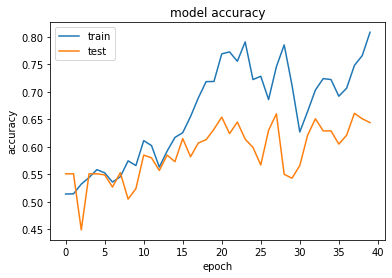

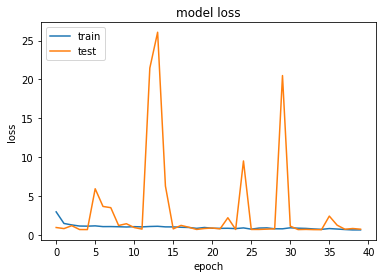

32/32 [==============================] - 0s 13ms/step - loss: 0.7274 - accuracy: 0.6610
Epoch 1/40
125/125 [==============================] - ETA: 0s - loss: 2.8050 - accuracy: 0.5192
Epoch 1: val_accuracy improved from -inf to 0.55100, saving model to /content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_5.h5
125/125 [==============================] - 17s 74ms/step - loss: 2.8050 - accuracy: 0.5192 - val_loss: 0.8032 - val_accuracy: 0.5510
Epoch 2/40
125/125 [==============================] - ETA: 0s - loss: 1.3840 - accuracy: 0.5140
Epoch 2: val_accuracy did not improve from 0.55100
125/125 [==============================] - 6s 50ms/step - loss: 1.3840 - accuracy: 0.5140 - val_loss: 0.7363 - val_accuracy: 0.5510
Epoch 3/40
124/125 [============================>.] - ETA: 0s - loss: 1.3941 - accuracy: 0.5280
Epoch 3: val_accuracy did not improve from 0.55100
125/125 [==============================] - 5s 42ms/step - loss: 1.3897 - accuracy: 0.5285 - val_loss: 0.6981 - val_accurac

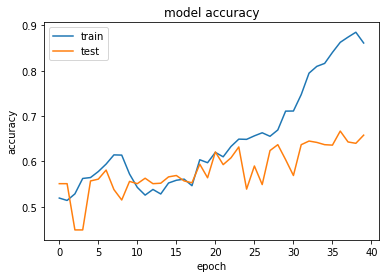

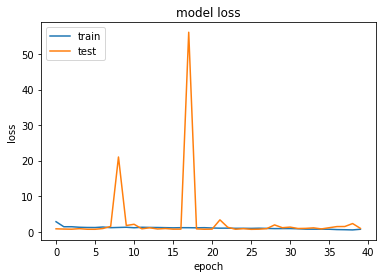

32/32 [==============================] - 1s 17ms/step - loss: 1.4362 - accuracy: 0.6670


In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []


save_dir = '/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/'
fold_var = 1

from sklearn.model_selection import KFold, StratifiedKFold

skf = StratifiedKFold(5, random_state = 7, shuffle = True) 

for train_index,val_index in skf.split(X,Y):
  x_train,x_val= X[train_index],X[val_index]
  y_train,y_val=Y[train_index],Y[val_index]

  #y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  #y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

  model = create_new_model()

  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]
  
  history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=40, shuffle=True, callbacks=callbacks_list, validation_data = (x_val,y_val))
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  model.load_weights("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_"+str(fold_var)+".h5")
  
  results = model.evaluate(x=x_val, y=y_val)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  tf.keras.backend.clear_session()

  
  fold_var+=1

In [ ]:
print(VALIDATION_ACCURACY)

[0.6309999823570251, 0.6359999775886536, 0.6480000019073486, 0.6610000133514404, 0.6669999957084656]


In [ ]:
model = create_new_model()
model.load_weights("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/model_5.h5")
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [ ]:
all_data = data_zipped.getnames()

In [ ]:
white_total = 0
black_total = 0
asian_total = 0
indian_total = 0
others_total = 0
files = []
for i in tqdm(all_data):
  if len(i.split('_')) != 4:
    continue

  loc = 'drive/My Drive/ASDRP/Data/utk_cropped/' + i
  #print(i.split('_')[2] == 0)
  #break
  if loc not in df['image'].values and int(i.split('_')[2]) == 0 and white_total <= 200:
    files.append(i)
    white_total += 1
  
  if loc not in df['image'].values and int(i.split('_')[2]) == 1 and black_total <= 200:
    files.append(i)
    black_total += 1

  if loc not in df['image'].values and int(i.split('_')[2]) == 2 and asian_total <= 200:
    files.append(i)
    asian_total += 1

  if loc not in df['image'].values and int(i.split('_')[2]) == 3 and indian_total <= 200:
    files.append(i)
    indian_total += 1

  if loc not in df['image'].values and int(i.split('_')[2]) == 4 and others_total <= 200:
    files.append(i)
    others_total += 1

100%|██████████| 10138/10138 [00:09<00:00, 1118.21it/s]


In [ ]:
data = 'drive/My Drive/ASDRP/Experiments/test_data_real/'
image_paths = []
ages = []
genders = []
races = []

In [ ]:
# For loop to create individual lists of attributes
count = 0
for image in tqdm(files):
    image_path = os.path.join(data, image)
    vals = image.split('_')
    age = int(vals[0].split('/')[1])
    gender = int(vals[1])

    try:
      race = int(vals[2])    
    except:
      count += 1
      continue

    image_paths.append(image_path)
    ages.append(age)
    genders.append(gender)
    races.append(race) 

100%|██████████| 1004/1004 [00:00<00:00, 169432.74it/s]


In [ ]:
# Making dataframe
df_test = pd.DataFrame()
df_test['image'], df_test['age'], df_test['gender'], df_test['race'] = image_paths, ages, genders, races

In [ ]:
df_test = df_test.drop(df_test[df_test['race'] == 0].sample(1).index)

In [ ]:
df_test = df_test.drop(df_test[df_test['race'] == 2].sample(1).index)
df_test = df_test.drop(df_test[df_test['race'] == 3].sample(1).index)
df_test = df_test.drop(df_test[df_test['race'] == 4].sample(1).index)

In [ ]:
df_test['race'].value_counts()

2    200
0    200
3    200
4    200
1    200
Name: race, dtype: int64

In [ ]:
df_test['image']

0       drive/My Drive/ASDRP/Experiments/test_data_rea...
1       drive/My Drive/ASDRP/Experiments/test_data_rea...
2       drive/My Drive/ASDRP/Experiments/test_data_rea...
3       drive/My Drive/ASDRP/Experiments/test_data_rea...
4       drive/My Drive/ASDRP/Experiments/test_data_rea...
                              ...                        
999     drive/My Drive/ASDRP/Experiments/test_data_rea...
1000    drive/My Drive/ASDRP/Experiments/test_data_rea...
1001    drive/My Drive/ASDRP/Experiments/test_data_rea...
1002    drive/My Drive/ASDRP/Experiments/test_data_rea...
1003    drive/My Drive/ASDRP/Experiments/test_data_rea...
Name: image, Length: 1000, dtype: object

In [ ]:
df_test.to_csv(r'drive/My Drive/ASDRP/Experiments/df_test.csv', index = False, header=True)

In [ ]:
for i in tqdm(df_test['image']):
  i = i.replace('drive/My Drive/ASDRP/Experiments/test_data_real/', '')
  data_zipped.extract(i, 'drive/My Drive/ASDRP/Experiments/test_data_real')

100%|██████████| 1000/1000 [00:13<00:00, 76.65it/s]


In [ ]:
images_test = [load(i) for i in tqdm(df_test.image)]

100%|██████████| 1000/1000 [00:09<00:00, 105.27it/s]


In [ ]:
with open('/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle', 'wb') as handle:
  pickle.dump(images_test, handle)

In [ ]:
images_test = pickle.load(open("/content/drive/MyDrive/ASDRP/Experiments/simple-cnn-v3/test_tensors_generated.pickle", "rb"))

In [ ]:
images_test = np.array(images_test)

In [ ]:
y_gender_test = [i for i in df_test['gender']]
# y_age = [i for i in df['age']]
y_race_test = [i for i in df_test['race']]

In [ ]:
y_stack_test = np.vstack((y_gender_test,y_race_test))

In [ ]:
X_test = images_test
y_test = y_stack_test[0]

In [ ]:
y_alias2 = y_stack_test[1]

In [ ]:
from sklearn.metrics import confusion_matrix
import keras
X_test = np.array(X_test)
y_test = np.array(y_test)
race_total = {'White':0, 'Black': 0, 'Asian': 0, 'Indian': 0, 'Others': 0, 'White F':0, 'Black F': 0, 'Asian F': 0, 'Indian F': 0, 'Others F': 0}
race_correct = {'White':0, 'Black': 0, 'Asian': 0, 'Indian': 0, 'Others': 0, 'White F':0, 'Black F': 0, 'Asian F': 0, 'Indian F': 0, 'Others F': 0}
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
test_acc_metric = keras.metrics.BinaryAccuracy()
list2 = []
predictions = []

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(1)
for step, (x_batch_test, y_batch_test) in enumerate(test_dataset):
  if y_test[step] == 0:
    if y_alias2[step] == 0:
        race_total['White'] += 1
    elif y_alias2[step] == 1:
        race_total['Black'] += 1
    elif y_alias2[step] == 2:
        race_total['Asian'] += 1
    elif y_alias2[step] == 3:
        race_total['Indian'] += 1  
    elif y_alias2[step] == 4:
        race_total['Others'] += 1
  else:
    if y_alias2[step] == 0:
        race_total['White F'] += 1
    elif y_alias2[step] == 1:
        race_total['Black F'] += 1
    elif y_alias2[step] == 2:
        race_total['Asian F'] += 1
    elif y_alias2[step] == 3:
        race_total['Indian F'] += 1  
    elif y_alias2[step] == 4:
        race_total['Others F'] += 1
  with tf.GradientTape() as tape:
    logits = model(x_batch_test, training=False)
    if logits >= 0.5:
      predictions.append(1)
    else:
      predictions.append(0)
    loss_value = loss_fn(y_batch_test,logits)
    test_acc_metric.update_state(y_batch_test, logits)
    list2.append(test_acc_metric.result().numpy())
  if step >= 1:
    if list2[step] >= list2[step-1]:
      if y_test[step] == 0:
        if y_alias2[step] == 0:
          race_correct['White'] += 1
        elif y_alias2[step] == 1:
          race_correct['Black'] += 1
        elif y_alias2[step] == 2:
          race_correct['Asian'] += 1
        elif y_alias2[step] == 3:
          race_correct['Indian'] += 1
        elif y_alias2[step] == 4:
          race_correct['Others'] += 1
      else:
        if y_alias2[step] == 0:
          race_correct['White F'] += 1
        elif y_alias2[step] == 1:
          race_correct['Black F'] += 1
        elif y_alias2[step] == 2:
          race_correct['Asian F'] += 1
        elif y_alias2[step] == 3:
          race_correct['Indian F'] += 1
        elif y_alias2[step] == 4:
          race_correct['Others F'] += 1
      

  if step % 100 == 0:
            print(
                "Testing loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1)))

test_acc = test_acc_metric.result()
print("Testing acc %.4f" % (float(test_acc),))


Testing loss (for one batch) at step 0: 0.5344
Seen so far: 1 samples
Testing loss (for one batch) at step 100: 0.7365
Seen so far: 101 samples
Testing loss (for one batch) at step 200: 0.6941
Seen so far: 201 samples
Testing loss (for one batch) at step 300: 0.4170
Seen so far: 301 samples
Testing loss (for one batch) at step 400: 0.6971
Seen so far: 401 samples
Testing loss (for one batch) at step 500: 1.3126
Seen so far: 501 samples
Testing loss (for one batch) at step 600: 1.2410
Seen so far: 601 samples
Testing loss (for one batch) at step 700: 1.1911
Seen so far: 701 samples
Testing loss (for one batch) at step 800: 0.3647
Seen so far: 801 samples
Testing loss (for one batch) at step 900: 0.9919
Seen so far: 901 samples
Testing acc 0.6290


In [ ]:
df_test['gender'].value_counts()

1    550
0    450
Name: gender, dtype: int64

In [ ]:
race_total

{'Asian': 100,
 'Asian F': 100,
 'Black': 101,
 'Black F': 99,
 'Indian': 73,
 'Indian F': 127,
 'Others': 95,
 'Others F': 105,
 'White': 81,
 'White F': 119}

In [ ]:
race_correct

{'Asian': 54,
 'Asian F': 63,
 'Black': 66,
 'Black F': 62,
 'Indian': 41,
 'Indian F': 89,
 'Others': 56,
 'Others F': 71,
 'White': 51,
 'White F': 78}

In [ ]:
for i in race_total:
  print(f'Percentage of {i} class in testing dataset: {round(race_total[i]/sum(race_total.values()), 2) * 100} %')
  print(f'Testing accuracy of {i} class: {round(float(race_correct[i] / race_total[i]),3) * 100} %')

Percentage of White class in testing dataset: 8.0 %
Testing accuracy of White class: 63.0 %
Percentage of Black class in testing dataset: 10.0 %
Testing accuracy of Black class: 65.3 %
Percentage of Asian class in testing dataset: 10.0 %
Testing accuracy of Asian class: 54.0 %
Percentage of Indian class in testing dataset: 7.000000000000001 %
Testing accuracy of Indian class: 56.2 %
Percentage of Others class in testing dataset: 10.0 %
Testing accuracy of Others class: 58.9 %
Percentage of White F class in testing dataset: 12.0 %
Testing accuracy of White F class: 65.5 %
Percentage of Black F class in testing dataset: 10.0 %
Testing accuracy of Black F class: 62.6 %
Percentage of Asian F class in testing dataset: 10.0 %
Testing accuracy of Asian F class: 63.0 %
Percentage of Indian F class in testing dataset: 13.0 %
Testing accuracy of Indian F class: 70.1 %
Percentage of Others F class in testing dataset: 10.0 %
Testing accuracy of Others F class: 67.60000000000001 %
